<a href="https://colab.research.google.com/github/simbar1123/Data-Science-Project-Example/blob/main/Project_3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Project 3** 

Lets acquire our data and then load all the varying libraries/functions we may want:

In [ ]:
import numpy as np
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt # this is used for the plot the graph 
import os
import seaborn as sns # used for plot interactive graph.
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn import metrics
from sklearn.svm import SVC  
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.cluster import KMeans
from sklearn.metrics import confusion_matrix
import sklearn.metrics.cluster as smc
from sklearn.model_selection import KFold


from matplotlib import pyplot
import itertools

%matplotlib inline

import random 

In [ ]:
# Helper function that allows you to draw nicely formatted confusion matrices
def draw_confusion_matrix(y, yhat, classes):
    '''
        Draws a confusion matrix for the given target and predictions
        Adapted from scikit-learn and discussion example.
    '''
    plt.cla()
    plt.clf()
    matrix = confusion_matrix(y, yhat)
    plt.imshow(matrix, interpolation='nearest', cmap=plt.cm.Blues)
    plt.title("Confusion Matrix")
    plt.colorbar()
    num_classes = len(classes)
    plt.xticks(np.arange(num_classes), classes, rotation=90)
    plt.yticks(np.arange(num_classes), classes)
    
    fmt = 'd'
    thresh = matrix.max() / 2.
    for i, j in itertools.product(range(matrix.shape[0]), range(matrix.shape[1])):
        plt.text(j, i, format(matrix[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if matrix[i, j] > thresh else "black")

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()
    plt.show()

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

sdata = pd.read_csv("/content/drive/My Drive/dataset-stroke.csv")

Mounted at /content/drive


Let's take a super quick look at our data just to see what he have going on

In [ ]:
sdata.head()

,Unnamed: 0,id,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke
0,2764,20292,Female,24.0,0,0,Yes,Private,Urban,85.55,63.3,never smoked,0
1,98,8154,Male,57.0,1,0,Yes,Govt_job,Urban,78.92,27.7,formerly smoked,1
2,3735,27176,Female,69.0,0,0,Yes,Private,Rural,103.73,34.7,never smoked,0
3,4500,13598,Male,60.0,0,0,Yes,Self-employed,Urban,227.23,40.0,formerly smoked,0
4,3254,27034,Female,65.0,0,0,Yes,Govt_job,Urban,82.72,29.8,smokes,0


In [ ]:
sdata.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2310 entries, 0 to 2309
Data columns (total 13 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Unnamed: 0         2310 non-null   int64  
 1   id                 2310 non-null   int64  
 2   gender             2310 non-null   object 
 3   age                2310 non-null   float64
 4   hypertension       2310 non-null   int64  
 5   heart_disease      2310 non-null   int64  
 6   ever_married       2310 non-null   object 
 7   work_type          2310 non-null   object 
 8   Residence_type     2310 non-null   object 
 9   avg_glucose_level  2310 non-null   float64
 10  bmi                2215 non-null   float64
 11  smoking_status     2310 non-null   object 
 12  stroke             2310 non-null   int64  
dtypes: float64(3), int64(5), object(5)
memory usage: 234.7+ KB


In [ ]:
sdata.describe()

,Unnamed: 0,id,age,hypertension,heart_disease,avg_glucose_level,bmi,stroke
count,2310.000000,2310.000000,2310.000000,2310.000000,2310.000000,2310.000000,2215.000000,2310.000000
mean,2530.838095,35961.380519,43.202043,0.096537,0.054545,105.747004,28.805418,0.052814
std,1483.865940,21191.909528,22.784886,0.295390,0.227140,44.984524,7.800871,0.223710
min,0.000000,77.000000,0.080000,0.000000,0.000000,55.120000,10.300000,0.000000
25%,1217.250000,17007.750000,25.250000,0.000000,0.000000,77.007500,23.600000,0.000000
50%,2573.500000,36047.000000,44.000000,0.000000,0.000000,91.850000,28.100000,0.000000
75%,3810.750000,54231.500000,61.000000,0.000000,0.000000,113.452500,32.900000,0.000000
max,5109.000000,72918.000000,82.000000,1.000000,1.000000,271.740000,92.000000,1.000000


I will discuss this more thourougholy in the report section of this project, but I did some outside research and the features I have decided to drop are id, ever_married, and residence type.  I am going to drop these features again in the pipeline, but I want to have a second set of the same data with the features dropped to look at some basic statistices/correlations

In [ ]:
sdata2 = sdata.drop(["Unnamed: 0", "id", "ever_married", "Residence_type"],axis=1)
sdata2.head()

,gender,age,hypertension,heart_disease,work_type,avg_glucose_level,bmi,smoking_status,stroke
0,Female,24.0,0,0,Private,85.55,63.3,never smoked,0
1,Male,57.0,1,0,Govt_job,78.92,27.7,formerly smoked,1
2,Female,69.0,0,0,Private,103.73,34.7,never smoked,0
3,Male,60.0,0,0,Self-employed,227.23,40.0,formerly smoked,0
4,Female,65.0,0,0,Govt_job,82.72,29.8,smokes,0


Let's do a quick correlation plot as we did with project 2

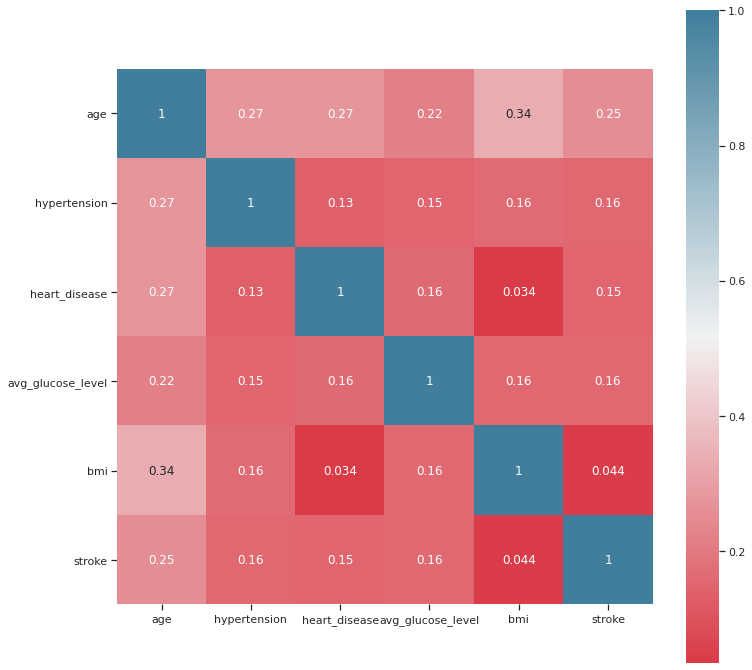

In [ ]:
# we will set up a correlation plot but with a nicer color scheme so we can better visualize our results
import matplotlib.transforms

sns.set(style = "ticks")
corr = sdata2.corr()
f,ax = plt.subplots(figsize = (12,12))
colorM = sns.diverging_palette(10,230,as_cmap=True)
sns.heatmap(corr,annot=True,cmap = colorM, square=True)

From this plot we can gain some information about what features may or may not be correlated.



*   The strongest correlation is between age and BMI, which makes sense as metabolisms slow down with age thus making weight gain easier
*   There are also notable positive correlations relating age with heart disease and hypertension.
*   The correlation between BMI and heart disease is much lower than I expected





One more stat I am interested in that I believe could be informative:

BMI: Lets examine the average and distribution of the BMI values.  The USA is notoriously overweight, so I would like to see if this data is balanced.  Keep in mind, the CDC has the following BMI classifications


1.   $<$18.5 = underweight
2.   18.5-24.9 = normal/healthy weight
3.   25.0-29.9 = overweight
4.   $>$30.0 = obese





mean BMI: 28.80541760722349
median BMI: 28.1


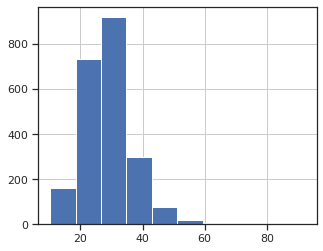

In [ ]:
BMI = sdata2["bmi"].copy()
print("mean BMI:", BMI.mean())
print("median BMI:", BMI.median())
BMI.hist(bins=10,figsize=(5,4));

As I (unfortunately) anticipated, it seems that the majority of people in this study are either overweight or obese.  This is important to consieder in our analysis, as data from a less overweight area may provide different results.

**Part 2**

As I mentioned above, I plan to drop id, ever_married, and residence type.  The remaining categories can be divided into categorical and numerical categories.  The categorical categories are gender, hypertension, heart disease, work type, and smoking status.  That makes the numerical categories age avg_glucose and bmi.  Let's now examine null values to see what needs to be imputed.

In [ ]:
nulls = sdata[sdata.isnull().any(axis=1)]
nulls.describe()

,Unnamed: 0,id,age,hypertension,heart_disease,avg_glucose_level,bmi,stroke
count,95.000000,95.000000,95.000000,95.000000,95.000000,95.000000,0.0,95.000000
mean,1987.063158,24790.515789,53.369684,0.242105,0.157895,131.374947,NaN,0.242105
std,1503.073453,21901.551706,22.994452,0.430630,0.366577,59.704068,NaN,0.430630
min,1.000000,224.000000,0.480000,0.000000,0.000000,57.920000,NaN,0.000000
25%,419.500000,5729.000000,34.500000,0.000000,0.000000,79.750000,NaN,0.000000
50%,1866.000000,18234.000000,59.000000,0.000000,0.000000,104.450000,NaN,0.000000
75%,3136.500000,40143.500000,73.500000,0.000000,0.000000,196.720000,NaN,0.000000
max,5105.000000,70676.000000,82.000000,1.000000,1.000000,240.690000,NaN,1.000000


It looks like BMI is going to be the problematice field.  Most educated people know that BMI is not a great measurement on an individual level, it doesn't account for things like increased density of incredibly muscular people.  However, at a population level BMI is a decenet indicator of general physical fitness.  Of course I would not (and no one should) attempt to predict likeliness of stroke strictly based off of BMI, but it has merit as one element of a prediction algorithm.  Now for the imputation method: here I have done some research which I will briefly summarize here and explain in more detail in the report.

IJCMR Article: there is correlation between BMI and glucose levels
https://www.ijcmr.com/uploads/7/7/4/6/77464738/ijcmr_1592.pdf

NIH Article: there is significant linear correlation between BMI and blood pressure, thus hypertension suggests higher BMI

https://www.ncbi.nlm.nih.gov/pmc/articles/PMC6316192/

Ok, I want to collect some stats to examine how best to impute BMI, first, I want to isolate the non-null columns and examine the ratio of bmi to average glucose levels.

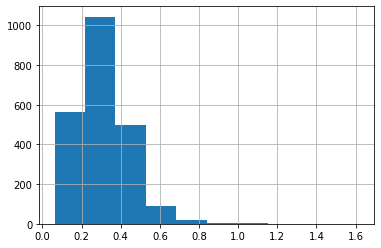

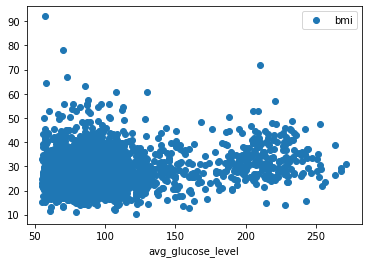

In [ ]:
nonull = sdata[sdata.notnull().any(axis=1)]
nonull['bmiTOgl']=nonull['bmi']/nonull['avg_glucose_level']
nonull['bmiTOgl'].hist();
nonull.plot(x='avg_glucose_level', y='bmi', style='o');


Ok, we definitely have some correlation here, so I think this is a good strategy for imputing BMI, certainly better than just slapping the mean or median everywhere

Lets start implementing this pipeline.

In [ ]:
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import OneHotEncoder
from sklearn import impute


#this is temporary so I can rerun my pipeline for testing
sdata = pd.read_csv("/content/drive/My Drive/dataset-stroke.csv")

#first thing we want to do is completely drop the features we don't need and remove the stroke column and save it seperately
strokes = sdata['stroke']
sdata = sdata.drop(["Unnamed: 0", "id", "ever_married", "Residence_type", "stroke"],axis=1)


#now lets impute our missing BMI based on glucose levels
non = sdata[sdata.notnull().any(axis=1)]
non['bmiTOgl']=non['bmi']/non['avg_glucose_level']
l = (non['bmiTOgl'].median())

sdata['bmi']=sdata.apply(
    lambda row: row['avg_glucose_level']*l if np.isnan(row['bmi']) else row['bmi'],
    axis = 1
)

#alright, BMI has been imputed, now lets do a quick augmentation.  I personally don't believe that these features are great for augmentation, but Its worth a shot
3#I will do a feature cross of age and glucose level that is simply a multiplication of the two. 
#both increased age and increased glucose level are known to cause health problems, 
#this is a numerical feature and it kind of offsets the inneffectiveness of BMI by simultaneously considering glucose levels

sdata['glage'] = sdata['avg_glucose_level']*sdata['age']

# i will now run my pipeline using standard scaler for the numerical data and onehotencoder for the categorical data as this seemed to work in project 2
#first lets split numerical and categorical features

sdata_removed = sdata.drop(["gender", "hypertension", "heart_disease", "work_type", "smoking_status"],axis=1)
nums = list(sdata_removed)
cats = ["gender", "hypertension", "heart_disease", "work_type", "smoking_status"]

full_pipeline = ColumnTransformer([
         ("num", StandardScaler(), nums),
         ("cat", OneHotEncoder(sparse=False), cats)                          
])

pdata = full_pipeline.fit_transform(sdata)






**Note**

This data is NOT well balanced, there are far more stroke havers than non stroke havers, thus we will run some models on the data and then leverage ensembling, I don't think over/under sampling is a good idea here nescessarily.  I expect these initial models to perform poorly until ensembling has occurred

In [ ]:
from sklearn.model_selection import train_test_split

#first things first: we will split the data into test and train sections
xtrain, xtest, ytrain, ytest = train_test_split(pdata, strokes, test_size = 0.25, random_state = 44)


**Logistic**



In [ ]:
from sklearn.linear_model import LogisticRegression

ryur = LogisticRegression(random_state = 55)

ryur.fit(xtrain,ytrain)
logistic_predictions = ryur.predict(xtest)


now lets take a look at our results:

The accuracy of this model is:  0.9463667820069204
The precision of this model is:  0.6666666666666666
The recall of this model is:  0.0625
The F1 score of this model is:  0.11428571428571428


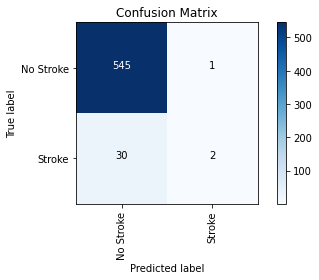

In [ ]:
print("The accuracy of this model is: ", metrics.accuracy_score(ytest,logistic_predictions))
print("The precision of this model is: ", metrics.precision_score(ytest,logistic_predictions))
print("The recall of this model is: ", metrics.recall_score(ytest,logistic_predictions))
print("The F1 score of this model is: ", metrics.f1_score(ytest,logistic_predictions))
draw_confusion_matrix(ytest, logistic_predictions, ["No Stroke", "Stroke"])

Alright, as expected its highly accurate but has bad marks for precision, recall, and F1.  We will likely have to ensemble before we get better results, it looks like the model is just classifying almost everything as a stroke from the lack of balance.

Let's employ PCA to reduce the complexity of our data frame.

In [ ]:
from sklearn.decomposition import PCA

pca1 = PCA()

pdata_pca=pdata

pca1.fit(pdata_pca)

print(pca1.explained_variance_ratio_)
print(pca1.singular_values_)
pdata_pca = pca1.fit_transform(pdata_pca)



[4.10988316e-01 1.47130906e-01 1.25348462e-01 7.88698330e-02
 5.58575237e-02 4.68635212e-02 3.03145681e-02 2.60974443e-02
 2.54901472e-02 2.24533340e-02 1.51147466e-02 9.64775822e-03
 4.78088558e-03 1.04255336e-03 4.73210246e-33 1.52527782e-33
 1.24243677e-33 4.52470498e-34 5.84310580e-37]
[7.60574449e+01 4.55070778e+01 4.20035985e+01 3.33182708e+01
 2.80393430e+01 2.56829231e+01 2.06563073e+01 1.91657572e+01
 1.89414475e+01 1.77773659e+01 1.45857051e+01 1.16530658e+01
 8.20315974e+00 3.83068233e+00 8.16120080e-15 4.63341789e-15
 4.18180850e-15 2.52360935e-15 9.06878005e-17]


Here we have printed our variance ratios and our singular values.  We will super quickly rerun our logistic regression to see how this behaves:

The accuracy of this model is:  0.8806228373702422
The precision of this model is:  0.2153846153846154
The recall of this model is:  0.4375
The F1 score of this model is:  0.28865979381443296


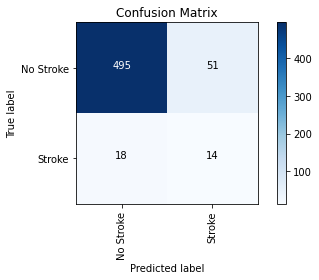

In [ ]:
xtrainp, xtestp, ytrainp, ytestp = train_test_split(pdata_pca, strokes, test_size = 0.25, random_state = 44)

ryur2 = LogisticRegression(random_state = 55)

ryur2.fit(xtrainp,ytrainp)
logistic_predictions = ryur.predict(xtestp)
print("The accuracy of this model is: ", metrics.accuracy_score(ytestp,logistic_predictions))
print("The precision of this model is: ", metrics.precision_score(ytestp,logistic_predictions))
print("The recall of this model is: ", metrics.recall_score(ytestp,logistic_predictions))
print("The F1 score of this model is: ", metrics.f1_score(ytestp,logistic_predictions))

draw_confusion_matrix(ytestp, logistic_predictions, ["No Stroke", "Stroke"])

Accuracy and precision are decreased, but recall and F1 are increased which suggests to me that this data actually performs better.  Beforehand it was classifying everything as non-stroke due to the lack of balance, but this seems to do a little bit better.

We will now do some bagging, and check the bagging results with a couple of different classifier methods, first we will use logistic regression again

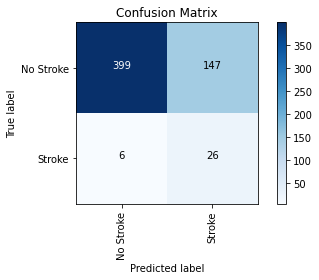

The accuracy of this model is:  0.7352941176470589
The precision of this model is:  0.15028901734104047
The recall of this model is:  0.8125
The F1 score of this model is:  0.25365853658536586


In [ ]:
#as I mentioned above, we will be using ensembling to help with our imbalnced data set
from imblearn.ensemble import BalancedBaggingClassifier 
bbc1 = BalancedBaggingClassifier(base_estimator=LogisticRegression(),
                                 sampling_strategy='auto',
                                 replacement = False,
                                 random_state=5)

bbc1.fit(xtrainp,ytrainp)
preds1=bbc1.predict(xtestp);


draw_confusion_matrix(ytestp, preds1, ["No Stroke", "Stroke"])

print("The accuracy of this model is: ", metrics.accuracy_score(ytestp,preds1))
print("The precision of this model is: ", metrics.precision_score(ytestp,preds1))
print("The recall of this model is: ", metrics.recall_score(ytestp,preds1))
print("The F1 score of this model is: ", metrics.f1_score(ytestp,preds1))

This model is in my opinion the best so far.  I want to minimize false negatives.  In my opinion its much better to have someone think they may have a stroke and thus possibly improve their health or consult their doctor about preventative measures than it is to mislead someone who is at risk of stroke.  Ideally one could avoid either, but I think this is progress.

I am now going to try the same bagging method with some different classifiers.

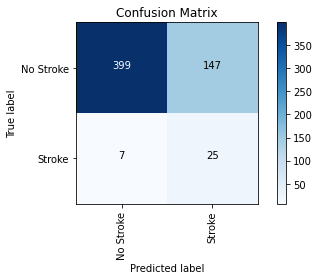

The accuracy of this model is:  0.7335640138408305
The precision of this model is:  0.14534883720930233
The recall of this model is:  0.78125
The F1 score of this model is:  0.2450980392156863


In [ ]:
from sklearn.neighbors import KNeighborsClassifier
bbc2 = BalancedBaggingClassifier(base_estimator=KNeighborsClassifier(),
                                 sampling_strategy='auto',
                                 replacement = False,
                                 random_state=5)

bbc2.fit(xtrainp,ytrainp)
preds2=bbc2.predict(xtestp);


draw_confusion_matrix(ytestp, preds2, ["No Stroke", "Stroke"])

print("The accuracy of this model is: ", metrics.accuracy_score(ytestp,preds2))
print("The precision of this model is: ", metrics.precision_score(ytestp,preds2))
print("The recall of this model is: ", metrics.recall_score(ytestp,preds2))
print("The F1 score of this model is: ", metrics.f1_score(ytestp,preds2))

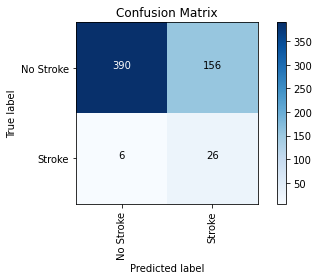

The accuracy of this model is:  0.7197231833910035
The precision of this model is:  0.14285714285714285
The recall of this model is:  0.8125
The F1 score of this model is:  0.24299065420560748


In [ ]:
from sklearn import svm
bbc3 = BalancedBaggingClassifier(base_estimator=svm.SVC(kernel='linear'),
                                 sampling_strategy='auto',
                                 replacement = False,
                                 random_state=5)

bbc3.fit(xtrainp,ytrainp)
preds3=bbc3.predict(xtestp);


draw_confusion_matrix(ytestp, preds3, ["No Stroke", "Stroke"])

print("The accuracy of this model is: ", metrics.accuracy_score(ytestp,preds3))
print("The precision of this model is: ", metrics.precision_score(ytestp,preds3))
print("The recall of this model is: ", metrics.recall_score(ytestp,preds3))
print("The F1 score of this model is: ", metrics.f1_score(ytestp,preds3))

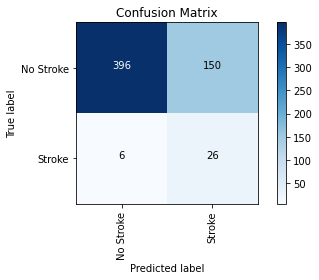

The accuracy of this model is:  0.7301038062283737
The precision of this model is:  0.14772727272727273
The recall of this model is:  0.8125
The F1 score of this model is:  0.25000000000000006


In [ ]:
from sklearn import svm
bbc4 = BalancedBaggingClassifier(base_estimator=svm.SVC(kernel='rbf'),
                                 sampling_strategy='auto',
                                 replacement = False,
                                 random_state=5)

bbc4.fit(xtrainp,ytrainp)
preds4=bbc4.predict(xtestp);


draw_confusion_matrix(ytestp, preds4, ["No Stroke", "Stroke"])

print("The accuracy of this model is: ", metrics.accuracy_score(ytestp,preds4))
print("The precision of this model is: ", metrics.precision_score(ytestp,preds4))
print("The recall of this model is: ", metrics.recall_score(ytestp,preds4))
print("The F1 score of this model is: ", metrics.f1_score(ytestp,preds4))

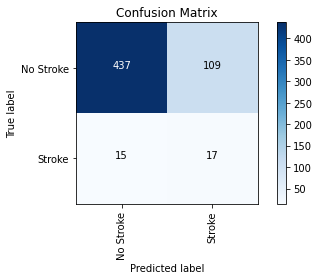

The accuracy of this model is:  0.7854671280276817
The precision of this model is:  0.1349206349206349
The recall of this model is:  0.53125
The F1 score of this model is:  0.21518987341772153


In [ ]:
from sklearn.tree import DecisionTreeClassifier
bbc5 = BalancedBaggingClassifier(base_estimator=DecisionTreeClassifier(),
                                 sampling_strategy='auto',
                                 replacement = False,
                                 random_state=5)

bbc5.fit(xtrainp,ytrainp)
preds5=bbc5.predict(xtestp);


draw_confusion_matrix(ytestp, preds5, ["No Stroke", "Stroke"])

print("The accuracy of this model is: ", metrics.accuracy_score(ytestp,preds5))
print("The precision of this model is: ", metrics.precision_score(ytestp,preds5))
print("The recall of this model is: ", metrics.recall_score(ytestp,preds5))
print("The F1 score of this model is: ", metrics.f1_score(ytestp,preds5))

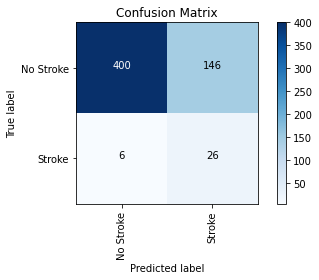

The accuracy of this model is:  0.7370242214532872
The precision of this model is:  0.1511627906976744
The recall of this model is:  0.8125
The F1 score of this model is:  0.2549019607843137


In [ ]:
from sklearn.naive_bayes import GaussianNB
bbc6 = BalancedBaggingClassifier(base_estimator=GaussianNB(),
                                 sampling_strategy='auto',
                                 replacement = False,
                                 random_state=5)

bbc6.fit(xtrainp,ytrainp)
preds6=bbc6.predict(xtestp);


draw_confusion_matrix(ytestp, preds6, ["No Stroke", "Stroke"])

print("The accuracy of this model is: ", metrics.accuracy_score(ytestp,preds6))
print("The precision of this model is: ", metrics.precision_score(ytestp,preds6))
print("The recall of this model is: ", metrics.recall_score(ytestp,preds6))
print("The F1 score of this model is: ", metrics.f1_score(ytestp,preds6))

Fitting a bunch of models gives a bunch of results with the same idea: solid accuracy, not as solid everything else.  It looks like false positives or false negatives may be unavoidable, and as I said before if I have to pick I'll take false positives.  Before doing some cross validation, we'll run a neural net classifier and see what happens.  

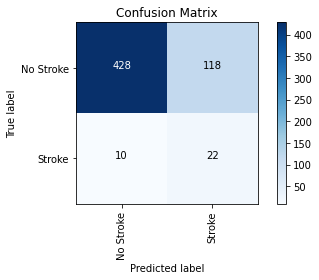

The accuracy of this model is:  0.7785467128027682
The precision of this model is:  0.15714285714285714
The recall of this model is:  0.6875
The F1 score of this model is:  0.2558139534883721


In [ ]:
#multi-layer perceptron
from sklearn.neural_network import MLPClassifier

bbc7 = BalancedBaggingClassifier(base_estimator=MLPClassifier(solver='lbfgs'),
                                 sampling_strategy='auto',
                                 replacement = False,
                                 random_state=5)

bbc7.fit(xtrainp,ytrainp)
preds7=bbc7.predict(xtestp);


draw_confusion_matrix(ytestp, preds7, ["No Stroke", "Stroke"])

print("The accuracy of this model is: ", metrics.accuracy_score(ytestp,preds7))
print("The precision of this model is: ", metrics.precision_score(ytestp,preds7))
print("The recall of this model is: ", metrics.recall_score(ytestp,preds7))
print("The F1 score of this model is: ", metrics.f1_score(ytestp,preds7))



At this point we have run a bunch of different models, so lets do some comparisons and see what we like the most.

In [ ]:
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score

kf = KFold(n_splits = 10)
#I will run the cross validation on models that I liked (I am going to try to pick those that optimize recall)

result1 = cross_val_score(bbc1,pdata_pca,strokes,cv=kf)
result2 = cross_val_score(bbc2,pdata_pca,strokes,cv=kf)
result3 = cross_val_score(bbc3,pdata_pca,strokes,cv=kf)
result4 = cross_val_score(bbc4,pdata_pca,strokes,cv=kf)
result6 = cross_val_score(bbc6,pdata_pca,strokes,cv=kf)


In [ ]:
print(result1.mean())
print(result2.mean())
print(result3.mean())
print(result4.mean())
print(result6.mean())

0.7523809523809525
0.7502164502164502
0.7476190476190475
0.7536796536796537
0.6926406926406926


These results are actually not too bad, my best result seems to be the SVM with radial bias function.  We will try to tweek a couple parameters and see if we can get it even a little better.

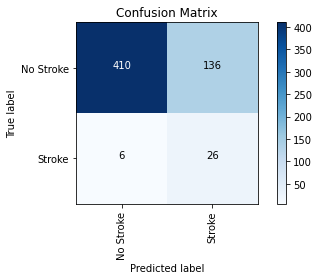

The accuracy of this model is:  0.754325259515571
The precision of this model is:  0.16049382716049382
The recall of this model is:  0.8125
The F1 score of this model is:  0.26804123711340205


In [ ]:
#we're going to tweek the following parameters:
#we will have an automatic weight balance applied to our predictors
#we will bootstrap our feature selection
#we will decrease the escape tolerance in our svm




bbcf = BalancedBaggingClassifier(base_estimator=svm.SVC(kernel='rbf', degree=5, class_weight='balanced', tol=1e-10),
                                 sampling_strategy='auto',
                                 replacement = False,
                                 bootstrap_features = True,
                                 random_state=5)

bbcf.fit(xtrainp,ytrainp)
predsf=bbcf.predict(xtestp);


draw_confusion_matrix(ytestp, predsf, ["No Stroke", "Stroke"])

print("The accuracy of this model is: ", metrics.accuracy_score(ytestp,predsf))
print("The precision of this model is: ", metrics.precision_score(ytestp,predsf))
print("The recall of this model is: ", metrics.recall_score(ytestp,predsf))
print("The F1 score of this model is: ", metrics.f1_score(ytestp,predsf))

In [ ]:
best_result = cross_val_score(bbcf,pdata_pca,strokes,cv=kf)
print(best_result.mean())

0.7588744588744588
